In [116]:
import numpy as np
from math import sqrt, log, log10
from scipy.stats import chi2

import torch.nn as nn
import torch
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [350]:
def generate_data(dataset_size, n, d, p, r, cp=None, seed=123):

    np.random.seed(seed)
    x = np.random.multivariate_normal(mean=np.zeros(d), cov=np.identity(d), size=(dataset_size, n))
    x = np.zeros((dataset_size, n, d))
    delta_theta = np.random.normal(loc=0, scale=1, size=(dataset_size, p))
    
    # provide a diverse delta_theta which norms are guaranteed greater than r
    if p <= d:
        delta_theta = np.hstack((np.zeros((dataset_size, d - p)), delta_theta)) # TODO: add shuffling
    delta_theta = np.random.uniform(r, 2 * r, size=dataset_size)[:, None] * delta_theta / np.linalg.norm(delta_theta, ord=2, axis=-1)[:, None]

    cp_idxs = []
    if cp is None:
        cp_idxs = np.random.randint(1, n-1, dataset_size)
    else:
        cp_idxs = [cp] * dataset_size

    for i in range(len(x)):
        x[i][cp_idxs[i]:] += delta_theta[i]
    return x, cp_idxs

In [351]:
d = 10
x, cp_idxs = generate_data(5, n + 1,  d,  p, r, cp)

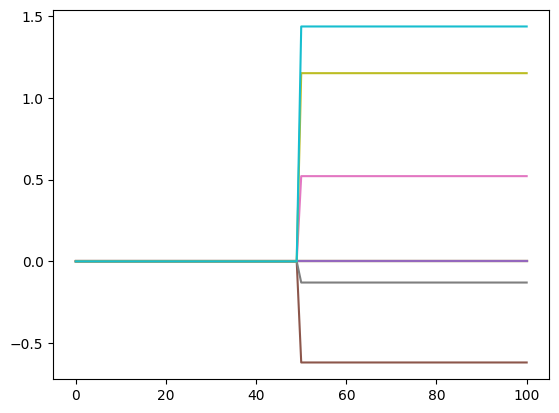

In [352]:
plt.plot(x[0]);

In [337]:
def calculate_z(x):
    n = x.shape[1] 
    z = []
    for i in range(1, n):
        z.append(sqrt(i * (n - i) / n) * (np.sum(x[:, 1:i+1, :], 1) / i - np.sum(x[:, i + 1:, :], 1) / (n - i)))
    z = np.array(z).transpose(1, 0, 2)
    return z

In [338]:
def calculate_l_lin(z):
    d = z.shape[-1]
    return (np.linalg.norm(z, axis=-1)**2 - d) / sqrt(2 * d)
    

def calculate_H(alpha, d):
    H = sqrt(2 * log(1 / alpha)) + sqrt(2 / d) * log(1 / alpha)
    # H = (chi2.ppf(1 - alpha, d) - d) / sqrt(2 * d)    
    return H

In [339]:
def detect_cps(x, alpha=0.05):
    z = calculate_z(x)
    l_lin = calculate_l_lin(z)
    n = z.shape[1]
    d = x.shape[-1]
    H = calculate_H(1 - alpha / (2 * n), d)

    detected_cp_idxs = []
    for seq in l_lin:
        tmp_cps = np.where(seq > H)[0]
        if len(tmp_cps) == 0:
            cp = -1
        else:
            cp = tmp_cps[np.argmax(seq[tmp_cps])] + 1 # because we generate n + 1 points to avoid zero-indexing
            cp += 1 # IDU why we need +1 more, but we need
        detected_cp_idxs.append(cp)
    return np.array(detected_cp_idxs), l_lin

In [340]:
samples_number = 10
n = 100
r = 1.8
p = 5
cp = 50

In [345]:
answer_dict = {}
for d in range(p, 50):
    x, cp_idxs = generate_data(samples_number, n + 1,  d,  p, r, cp)
    detected_cp_idxs, l_lin = detect_cps(x)
    answer_dict[d] = 1 - sum(detected_cp_idxs == -1) / len(detected_cp_idxs)

(10, 101, 5)
(10, 101, 6)
(10, 101, 7)
(10, 101, 8)
(10, 101, 9)
(10, 101, 10)
(10, 101, 11)
(10, 101, 12)
(10, 101, 13)
(10, 101, 14)
(10, 101, 15)
(10, 101, 16)
(10, 101, 17)
(10, 101, 18)
(10, 101, 19)
(10, 101, 20)
(10, 101, 21)
(10, 101, 22)
(10, 101, 23)
(10, 101, 24)
(10, 101, 25)
(10, 101, 26)
(10, 101, 27)
(10, 101, 28)
(10, 101, 29)
(10, 101, 30)
(10, 101, 31)
(10, 101, 32)
(10, 101, 33)
(10, 101, 34)
(10, 101, 35)
(10, 101, 36)
(10, 101, 37)
(10, 101, 38)
(10, 101, 39)
(10, 101, 40)
(10, 101, 41)
(10, 101, 42)
(10, 101, 43)
(10, 101, 44)
(10, 101, 45)
(10, 101, 46)
(10, 101, 47)
(10, 101, 48)
(10, 101, 49)


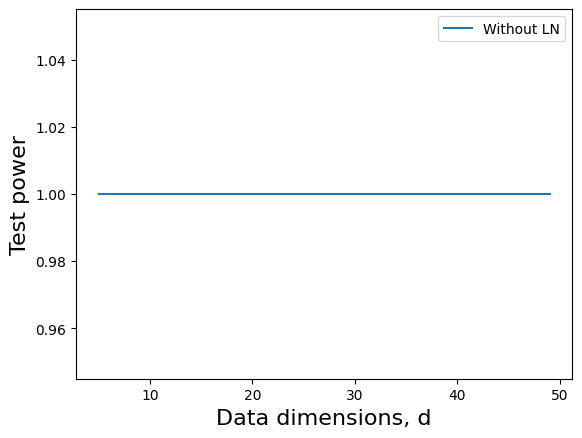

In [346]:
plt.plot(answer_dict.keys(), answer_dict.values(), label="Without LN")
plt.xlabel("Data dimensions, d", fontsize=16)
plt.ylabel("Test power", fontsize=16);
plt.legend()